In [1]:
import numpy as np
from scipy import misc
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [302]:


def load_mnist():
    # Loads the MNIST dataset from png images
 
    NUM_LABELS = 10        
    # create list of image objects
    test_images = []
    test_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob("MNIST/Test/" + str(label) + "/*.png"):
            image = misc.imread(image_path)
            test_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            test_labels.append(letter)  
            
    # create list of image objects
    train_images = []
    train_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob("MNIST/Train/" + str(label) + "/*.png"):
            image = misc.imread(image_path)
            train_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            train_labels.append(letter)                  
            
    X_train= np.array(train_images).reshape(-1,784)/255.0
    Y_train= np.array(train_labels)
    X_test= np.array(test_images).reshape(-1,784)/255.0
    Y_test= np.array(test_labels)
    
    return X_train, Y_train, X_test, Y_test


class NN():
    """
    Simple NN implementation for classification problems
    """
    def __init__(self):
        print("Model Initialized\nCall .model() to define your NN and .fit(x,y) to start the training process\n")
        pass

    ###################################
    #####          TOOLs         ######
    ###################################
    
    def onehot(self,arr):
        """
        Transoform input array into OneHotEncode format
        """
        a=np.array(arr)
        b = np.zeros((len(a), max(a)+1))
        b[np.arange(len(a)), a] = 1
        return b
    
    def shuffle(self,a,b):
        """
        Shuffle a and b arrays together
        """
        c = np.c_[a.reshape(len(a), -1),b.reshape(len(b), -1)]
        a2 = c[:, :a.size//len(a)].reshape(a.shape)
        b2 = c[:, a.size//len(a):].reshape(b.shape)
        np.random.shuffle(c)
        return a2,b2
    
    def model(self,units,activation):
        """
        Define the NN model details
        > units: tuple or list to specify dimensionality of W(l) weight matrices for each layer l
                 the last layer must have same dimension of n of classes
        > activation: tuple or list to specify activation function to be used in each output h(l)
        """
        self.start=0
        self.layers = len(units)
        self.units = units
        self.a_type = ['linear']+activation
        print("number of layers: ",self.layers)
        print("number of h-units",self.units)
        print("activation for each layer",activation)

    ###################################
    #####  ACTIVATION FUNCTIONS  ######
    ###################################
    
    def sigmoid(self,xx):
        """
        Compute the sigmoid of x
        """
        x=np.array(xx)
        s = lambda a: 1 / (1 + np.exp(-a))
        return s(x) 
    
    def relu(self,x):
        """
        Compute the relu of x
        """
        xx=np.array(x)
        xx[xx<0]=0
        return xx
    
    def softmax(self,xx):
        """
        Compute the softmax
        """
        x=np.array(xx)
        nm = np.exp(x-np.max(x))
        sm = (np.sum(nm,axis=1))
        temp=[]
        for i in range(nm.shape[-1]):
            temp.append(nm[:,i]/sm)
        return np.array(temp).T
    
    def softmax_derivatives(self,x):
        s = np.reshape(x,(-1,1))
        return np.diagflat(s) - np.dot(s, s.T)

    ###################################
    #######   LOSS FUNCTIONS   ########
    ###################################
    
    def cross_entropy(self,x,y,n):
        """
        Compute the cross entropy from a softmax output (x)
        y is the labels
        np should be in onehot format
        """
        loss = -1.0*np.sum(np.multiply(y,np.log(x)))/n
        return loss

    
    def accuracy(self,y,n):
        """
        Compute accuracy
        """
        tot=0.0
        for i in range(n):
            tot+=0.0 if np.argmax(self.h[-1][i])==np.argmax(y[i]) else 1.0
        return 1.0-tot/n


    ###################################
    #######    PROPAGATION     ########
    ###################################
    
    def activation(self,x,activation):
        if activation == 'sigmoid':
            return self.sigmoid(x)
        elif activation == 'relu':
            return self.relu(x)
        elif activation == 'softmax':
            return self.softmax(x)
        elif activation == 'linear':
            return np.array(x)
        else:
            print('Error with activation function specification')

    def act_derivative(self,xx,activation):
        x=np.array(xx)
        if activation == 'sigmoid':
            """
            Compute the derivative of the sigmoid
            """
            t=self.sigmoid(x)
            ds = t*np.subtract(1.0,t)
            return ds
        
        elif activation == 'relu':
            """
            Compute the derivative of the relu
            """
            ds=np.zeros_like(x)
            ds[np.where(x>0)]=1.0
            return ds
        
        elif activation == 'linear':
            """
            Compute the derivative of linear activation
            """
            return np.ones_like(x)
        
        else:
            print('Error with activation function specification')            
            
    def forward(self,x):
        """
        Process the forward propagation. Return the loss value and generate z=wx+b and h=actv(z)
        """
        #start forward process
        z=[]         #z=wx+b
        h=[]         #h=activation(z)
        z.append(x)
        h.append(x)
        for l in range(self.layers):
            z.append(np.matmul(self.w[l],h[l].reshape(len(h[l]),-1,1)).reshape(len(h[l]),-1)+self.b[l])
            h.append(self.activation(z[l+1],self.a_type[l+1])) 
        
        #global variables h,z to be used in backpropg
        self.h=h
        self.z=z        
        return 
    
    
    def backward2_obsolet(self,x,y):
        """
        Process the backpropagation and compute gradients
        """
        #start parameters
        final_grad=[]      #gradients/w
        final_grad_b=[]    #gradients/b
        phi=[]             #recurrent terms in backpropagation
         
        ### LAST LAYER (L)    
        #first term | derivative of Loss/softmax/output
        phi.append(np.subtract(self.h[-1],y))
        grad=[]
        for i in range(self.n):
            a=self.h[-2][i].reshape(1,-1)
            b=phi[0][i].reshape(-1,1)
            grad.append(np.matmul(b,a))
        final_grad.append(np.sum(grad,axis=0)/self.n)
        final_grad_b.append(np.sum(phi[0],axis=0)/self.n)
     
        if self.layers > 1:
            #loop for L-1 layers
            for l in range(1,self.layers):
                grad=[]
                temp_phi=[]
                d_actv=self.act_derivative(self.z[-l-1],self.a_type[-l-1])
                for i in range(self.n):
                    a=self.w[-l]
                    b=phi[l-1][i]
                    c=np.matmul(a.T,b)         
                    d=np.multiply(c,d_actv[i])
                    temp_phi.append(d)           
                    d=d.reshape(-1,1)
                    e=self.h[-l-2][i].reshape(-1,1) 
                    grad.append(np.matmul(d,e.T))                        
                phi.append(temp_phi)
                final_grad.append(np.sum(grad,axis=0)/self.n)
                final_grad_b.append(np.sum(phi[l],axis=0)/self.n)
               
        temp=[]
        temp2=[]
        for i in range(1,len(final_grad)+1):
            temp.append(np.array(final_grad[-i]))
            temp2.append(np.array(final_grad_b[-i]))
        
        #final gradient in correct order
        grad_w=temp
        grad_b=temp2
        return grad_w,grad_b
    
    
    def backward(self,x,y):
        """
        Process the backpropagation and compute gradients
        """
        #start parameters
        final_grad=[]      #gradients/w
        final_grad_b=[]    #gradients/b
        phi=[]             #recurrent terms in backpropagation
         
        ### LAST LAYER (L)    
        #first term | derivative of Loss/softmax/output
        phi.append(np.subtract(self.h[-1],y))
        a=self.h[-2].reshape(self.n,1,-1)
        b=phi[0].reshape(self.n,-1,1)
        #for first layer
        grad=np.matmul(b,a)
        final_grad.append(np.sum(grad,axis=0)/self.n)
        final_grad_b.append(np.sum(phi[0],axis=0)/self.n)
     
        if self.layers > 1:
            #loop for L-1 layers
            for l in range(1,self.layers):
                d_actv=self.act_derivative(self.z[-l-1],self.a_type[-l-1])
                a=self.w[-l]
                b=phi[l-1].reshape(self.n,-1,1)
                c=np.matmul(a.T,b).reshape(self.n,-1)            
                d=np.multiply(c,d_actv)
                phi.append(d)           
                d=d.reshape(self.n,-1,1)
                e=self.h[-l-2].reshape(self.n,1,-1) 
                grad=np.matmul(d,e)      
                final_grad.append(np.sum(grad,axis=0)/self.n)
                final_grad_b.append(np.sum(phi[l],axis=0)/self.n)
               
        temp=[]
        temp2=[]
        for i in range(1,len(final_grad)+1):
            temp.append(np.array(final_grad[-i]))
            temp2.append(np.array(final_grad_b[-i]))
        
        #final gradient in correct order
        grad_w=temp
        grad_b=temp2
        return grad_w,grad_b
    
    
        

    ###################################
    #######         FIT        ########
    ###################################
        
    def fit(self,x,y,epochs=100,lr=0.1,verbose=True,dc=True,test=None,n_batches=1,shuffle=True,init_rand=True):
        """
        Execute the training process, initializing and updating the network parameters
        At the end of fitting process, a dictionary will be returned with error and accuracy for each epoch

        >>>>> OPTIONS
        epochs: number of epochs to process the training
        n_batches: total number of batches (integer)
        shuffle: True/False to shuffle data at each epoch
        lr: learning rate. Float between 0,1
        dc: learning rate decay of type 1/x
        verbose: True/False to print results at each epoch
        test: list [X_test,Y_test] to validation
        """
        #initialize variables  
        keep_x=np.array(x)
        keep_y=np.array(y) #np.array(y)
        #history
        self.loss_history=[]
        self.acc_history=[]
        it_index=[]
        ep_index=[]
        
        #setting validation data
        if test is not None:
            #initialize test variables
            self.x_test=test[0]
            self.y_test=np.array(test[1])
            self.n_test=np.shape(self.y_test)[0]      
            #test history
            self.loss_history_test=[]
            self.acc_history_test=[]
            
        ## initiating iterations
        for it in range(epochs):
            #print(lr)
            #shuffle the data at each iteration
            if shuffle==True: 
                x,y=self.shuffle(keep_x,keep_y)
            else:
                x=keep_x
                y=keep_y
                
            #split the shuffled data at each iteration to get batches
            x=np.split(x,n_batches)
            y=np.split(y,n_batches)
            
            ## initiating batches
            cost=0.0
            acc=0.0
            for b_idx in range(n_batches):
                it_index.append(it*b_idx)
                self.x=x[b_idx]
                self.y=np.array(y[b_idx])
                self.n=np.shape(self.y)[0]
                
                ### STARTING WEIGHTS
                if self.start==0:         
                    #start parameters
                    w=[]
                    b=[]
                    if init_rand==False:
                        w.append(np.ones((self.units[0],self.x.shape[-1])))
                        b.append(np.ones((self.units[0])))
                        for l in range(self.layers-1):
                            w.append(np.ones((self.units[l+1],self.units[l])))
                            b.append(np.ones((self.units[l+1])))
                    elif init_rand=='rand':
                        w.append(np.random.rand(self.units[0],self.x.shape[-1]))
                        b.append(np.random.rand(self.units[0]))
                        for l in range(self.layers-1):
                            w.append(np.random.rand(self.units[l+1],self.units[l]))
                            b.append(np.random.rand(self.units[l+1]))
                    else:
                        w.append(np.random.normal(0,scale=0.01,size=(self.units[0],self.x.shape[-1])))
                        b.append(np.random.normal(0,scale=0.01,size=(self.units[0])))
                        for l in range(self.layers-1):
                            w.append(np.random.normal(0,scale=0.01,size=(self.units[l+1],self.units[l])))
                            b.append(np.random.normal(0,scale=0.01,size=(self.units[l+1])))
                    self.w=w
                    self.b=b
                    self.start=1
                ### END WEIGHTS  
                
                #initial values
                self.forward(self.x)
                grad_w,grad_b=self.backward(self.x,self.y)
                
                ######################    
                #starting optimization
                for i in range(len(grad_w)):
                    self.w[i] = self.w[i]-lr*grad_w[i]
                    self.b[i] = self.b[i]-lr*grad_b[i]
                
                #update cost and accuracy
                self.forward(self.x)
                cost=self.cross_entropy(self.h[-1],self.y,self.n)
                acc=self.accuracy(self.y,self.n)
                
                #acc=acc/n_batches    
                #cost=cost/n_batches    
                if test is not None:             
                    if b_idx == n_batches-1:
                        self.forward(self.x_test)
                        cost_test=self.cross_entropy(self.h[-1],self.y_test,self.n_test)
                        acc_test=self.accuracy(self.y_test,self.n_test)
                        print("%2d Batches, Epoch %2d -- Cost: %.3f Acc: %.3f  |-|  Test_Cost: %.3f | Acc: %.3f" %
                           (b_idx+1,it+1,cost,acc,cost_test,acc_test),end='\r') if verbose==True else None
                        self.loss_history.append(cost)
                        self.acc_history.append(acc)
                        self.loss_history_test.append(cost_test)
                        self.acc_history_test.append(acc_test)
                        ep_index.append(it*b_idx)
                    else:
                        print("%2d Batches, Epoch %2d -- Cost: %.3f Acc: %.3f" % (b_idx+1,it+1,cost,acc),end='\r') if verbose==True else None
                        self.loss_history.append(cost)
                        self.acc_history.append(acc)
                else:
                    print("%2d Batches, Epoch %2d -- Cost: %.3f Acc: %.3f" % (b_idx+1,it+1,cost,acc),end='\r') if verbose==True else None
                    self.loss_history.append(cost)
                    self.acc_history.append(acc)
            
            #jump one line
            print('')         
            
            #decay
            lr = lr*(1-2*lr/(it+1)) if dc == True else lr
            
        if test is not None:
            dic= {'Iterations':it_index,
                    'Epochs':ep_index,
                    'Error':self.loss_history,
                    'Accuracy':self.acc_history,
                    'TestError':self.loss_history_test,
                    'TestAccuracy':self.acc_history_test}
        else:
            dic= {'Iterations':it_index,
                    'Epochs':ep_index,
                    'Error':self.loss_history,
                    'Accuracy':self.acc_history}      
        return dic
    
    def get_w(self):
        """
        Get parameters after training
        """
        return self.w,self.b

    def evaluate(self,x,y):
        """
        Return the p[i] values for input data and print scores
        """
        #initialize variables
        n=len(x)
        self.forward(x)
        cost=self.cross_entropy(self.h[-1],y,n)
        acc=self.accuracy(y,n)
        #Print scores
        print("\nLoss: ",cost)
        print("Accuracy: ",acc,"\n")
        
        return self.h[-1]
        
    def predict(self,x):
        """
        Return the p[i] values for predictions
        """
        self.forward(x)
        return self.h[-1]


In [303]:
#X_train, Y_train, X_test, Y_test=load_mnist()

In [315]:
classifier = NN()

Model Initialized
Call .model() to define your NN and .fit(x,y) to start the training process



In [318]:
#defining model
units=[10]
activation=['softmax']
classifier.model(units,activation)

number of layers:  1
number of h-units [10]
activation for each layer ['softmax']


In [319]:
%%time
history=classifier.fit(X_train,Y_train,lr=0.1,epochs=20,n_batches=600,shuffle=True,test=[X_test,Y_test],init_rand=True)

600 Batches, Epoch  1 -- Cost: 0.489 Acc: 0.890  |-|  Test_Cost: 0.364 | Acc: 0.902
600 Batches, Epoch  2 -- Cost: 0.458 Acc: 0.850  |-|  Test_Cost: 0.328 | Acc: 0.910
600 Batches, Epoch  3 -- Cost: 0.418 Acc: 0.870  |-|  Test_Cost: 0.315 | Acc: 0.913
600 Batches, Epoch  4 -- Cost: 0.264 Acc: 0.890  |-|  Test_Cost: 0.305 | Acc: 0.918
600 Batches, Epoch  5 -- Cost: 0.357 Acc: 0.910  |-|  Test_Cost: 0.299 | Acc: 0.917
600 Batches, Epoch  6 -- Cost: 0.243 Acc: 0.960  |-|  Test_Cost: 0.294 | Acc: 0.918
600 Batches, Epoch  7 -- Cost: 0.365 Acc: 0.900  |-|  Test_Cost: 0.292 | Acc: 0.917
600 Batches, Epoch  8 -- Cost: 0.176 Acc: 0.950  |-|  Test_Cost: 0.289 | Acc: 0.919
600 Batches, Epoch  9 -- Cost: 0.206 Acc: 0.920  |-|  Test_Cost: 0.286 | Acc: 0.920
600 Batches, Epoch 10 -- Cost: 0.396 Acc: 0.890  |-|  Test_Cost: 0.285 | Acc: 0.920
600 Batches, Epoch 11 -- Cost: 0.237 Acc: 0.920  |-|  Test_Cost: 0.283 | Acc: 0.921
600 Batches, Epoch 12 -- Cost: 0.242 Acc: 0.940  |-|  Test_Cost: 0.281 | Acc

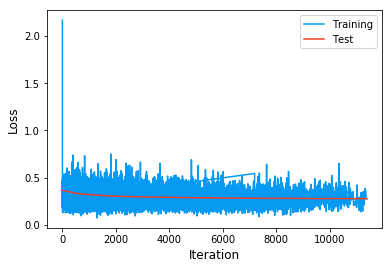

In [321]:
#plot errors hist
plt.plot(((history['Iterations'])),history['Error'],label='Training',c='xkcd:azure')
plt.plot(((history['Epochs'])),history['TestError'],label='Test',c='xkcd:tomato')
plt.ylabel('Loss',fontsize=12)
plt.xlabel('Iteration',fontsize=12)
plt.legend()
plt.savefig("error_oneL.png",dpi=300)

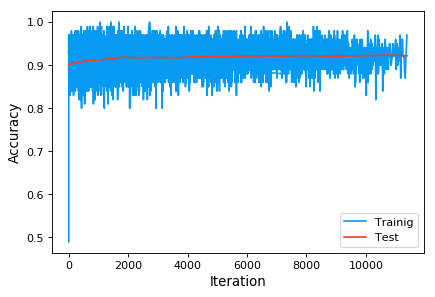

In [322]:
#plot accuracy hist
plt.figure(dpi=80)
plt.plot(((history['Iterations'])),history['Accuracy'],label="Trainig",c='xkcd:azure')
plt.plot(((history['Epochs'])),history['TestAccuracy'],label="Test",c='xkcd:tomato')
plt.ylabel('Accuracy',fontsize=12)
plt.xlabel('Iteration',fontsize=12)
plt.legend()
plt.savefig("acc_oneL.png",dpi=300)

In [323]:
#evaluate training
probs=classifier.evaluate(X_train,Y_train)


Loss:  0.2739901488193041
Accuracy:  0.92415 



In [324]:
#evaluating in test data
predictions=classifier.evaluate(X_test,Y_test)

#it is possible to call the "predict method" as well, which do not compute the loss function or accuracy
#predictions=classifier.predict(X_test)


Loss:  0.27541987653144595
Accuracy:  0.922 



In [325]:
#getting weigths
w,b=classifier.get_w()

In [326]:
w=np.reshape(w,(10,784))

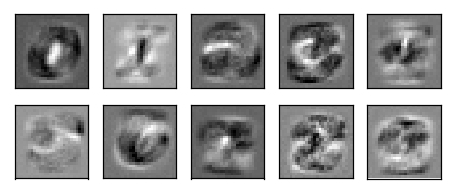

In [327]:
num_rows = 2
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(num_cols, num_rows),dpi=110)

for i in range(10):
    plt.subplot(num_rows, num_cols, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(w[i].reshape(28,28), cmap=plt.cm.binary)    


#plt.show()

plt.savefig("weights_oneL.png",dpi=300)

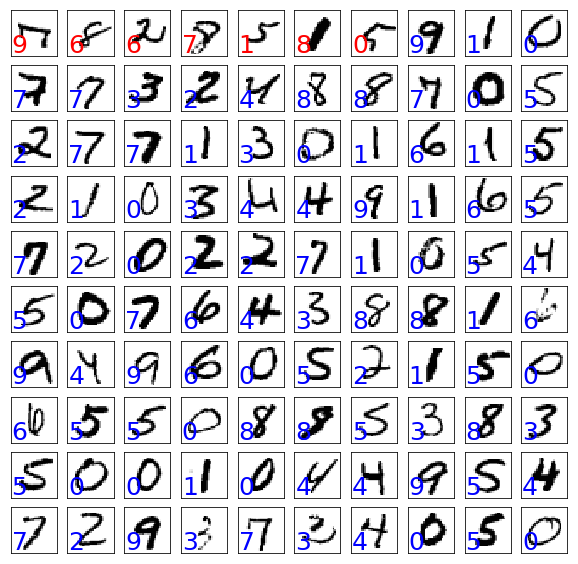

In [328]:
#converting
test_pred = np.argmax(predictions,axis=1)
test_true = np.argmax(Y_test,axis=1)
test_size = len(test_true)
test_data = np.array(X_test).reshape((10000, 28, 28, 1))

# Extract 100 random test images
batch_test_ind = np.random.choice(test_size,100)
batch_test_ind_wrong_first = batch_test_ind[np.argsort(test_true[batch_test_ind]==test_pred[batch_test_ind])]

# Do the plot of the images
num_rows = 10
num_cols = 10
num_images = num_rows*num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, i_im in enumerate(batch_test_ind_wrong_first, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[i_im,:,:,0], cmap=plt.cm.binary)    
    if test_pred[i_im]==test_true[i_im]:
          plt.text(0, 25, test_pred[i_im], fontsize=25, color='blue')
    else:
          plt.text(0, 25, test_pred[i_im], fontsize=25, color='red')    
                  
plt.savefig("numbers_oneL.png",dpi=300)


----

# Multilayer
----

In [329]:
classifier2=NN()

Model Initialized
Call .model() to define your NN and .fit(x,y) to start the training process



In [354]:
#defining model
units2=[200,10]
activation2=['relu','softmax']
classifier2.model(units2,activation2)

number of layers:  2
number of h-units [200, 10]
activation for each layer ['relu', 'softmax']


In [373]:
%%time
history=classifier2.fit(X_train,Y_train,lr=0.01,epochs=5,n_batches=100,test=[X_test,Y_test])

100 Batches, Epoch  1 -- Cost: 0.042 Acc: 0.987  |-|  Test_Cost: 0.096 | Acc: 0.975
100 Batches, Epoch  2 -- Cost: 0.023 Acc: 0.990  |-|  Test_Cost: 0.090 | Acc: 0.976
100 Batches, Epoch  3 -- Cost: 0.033 Acc: 0.990  |-|  Test_Cost: 0.087 | Acc: 0.977
100 Batches, Epoch  4 -- Cost: 0.020 Acc: 0.993  |-|  Test_Cost: 0.085 | Acc: 0.977


KeyboardInterrupt: 

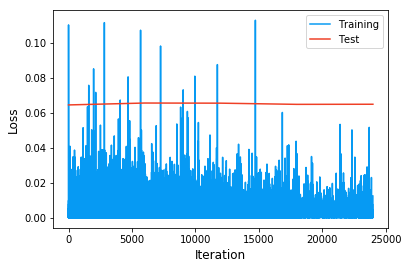

In [369]:
#plot errors hist
plt.plot(((history['Iterations'])),history['Error'],label='Training',c='xkcd:azure')
plt.plot(((history['Epochs'])),history['TestError'],label='Test',c='xkcd:tomato')
plt.ylabel('Loss',fontsize=12)
plt.xlabel('Iteration',fontsize=12)
plt.legend()
plt.savefig("error_2L.png",dpi=300)

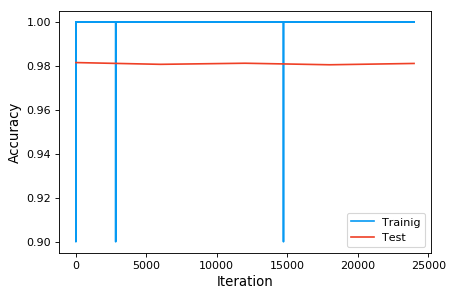

In [370]:
#plot accuracy hist
plt.figure(dpi=80)
plt.plot(((history['Iterations'])),history['Accuracy'],label="Trainig",c='xkcd:azure')
plt.plot(((history['Epochs'])),history['TestAccuracy'],label="Test",c='xkcd:tomato')
plt.ylabel('Accuracy',fontsize=12)
plt.xlabel('Iteration',fontsize=12)
plt.legend()
plt.savefig("acc_2L.png",dpi=300)

In [361]:
#evaluate training
probs2=classifier2.evaluate(X_train,Y_train)


Loss:  0.004718285821509068
Accuracy:  0.9997666666666667 



In [362]:
#evaluating in test data
predictions2=classifier2.evaluate(X_test,Y_test)

#it is possible to call the "predict method" as well, which do not compute the loss function or accuracy
#predictions=classifier.predict(X_test)


Loss:  0.06446170419303633
Accuracy:  0.9808 



In [363]:
#getting weigths
w2,b2=classifier2.get_w()

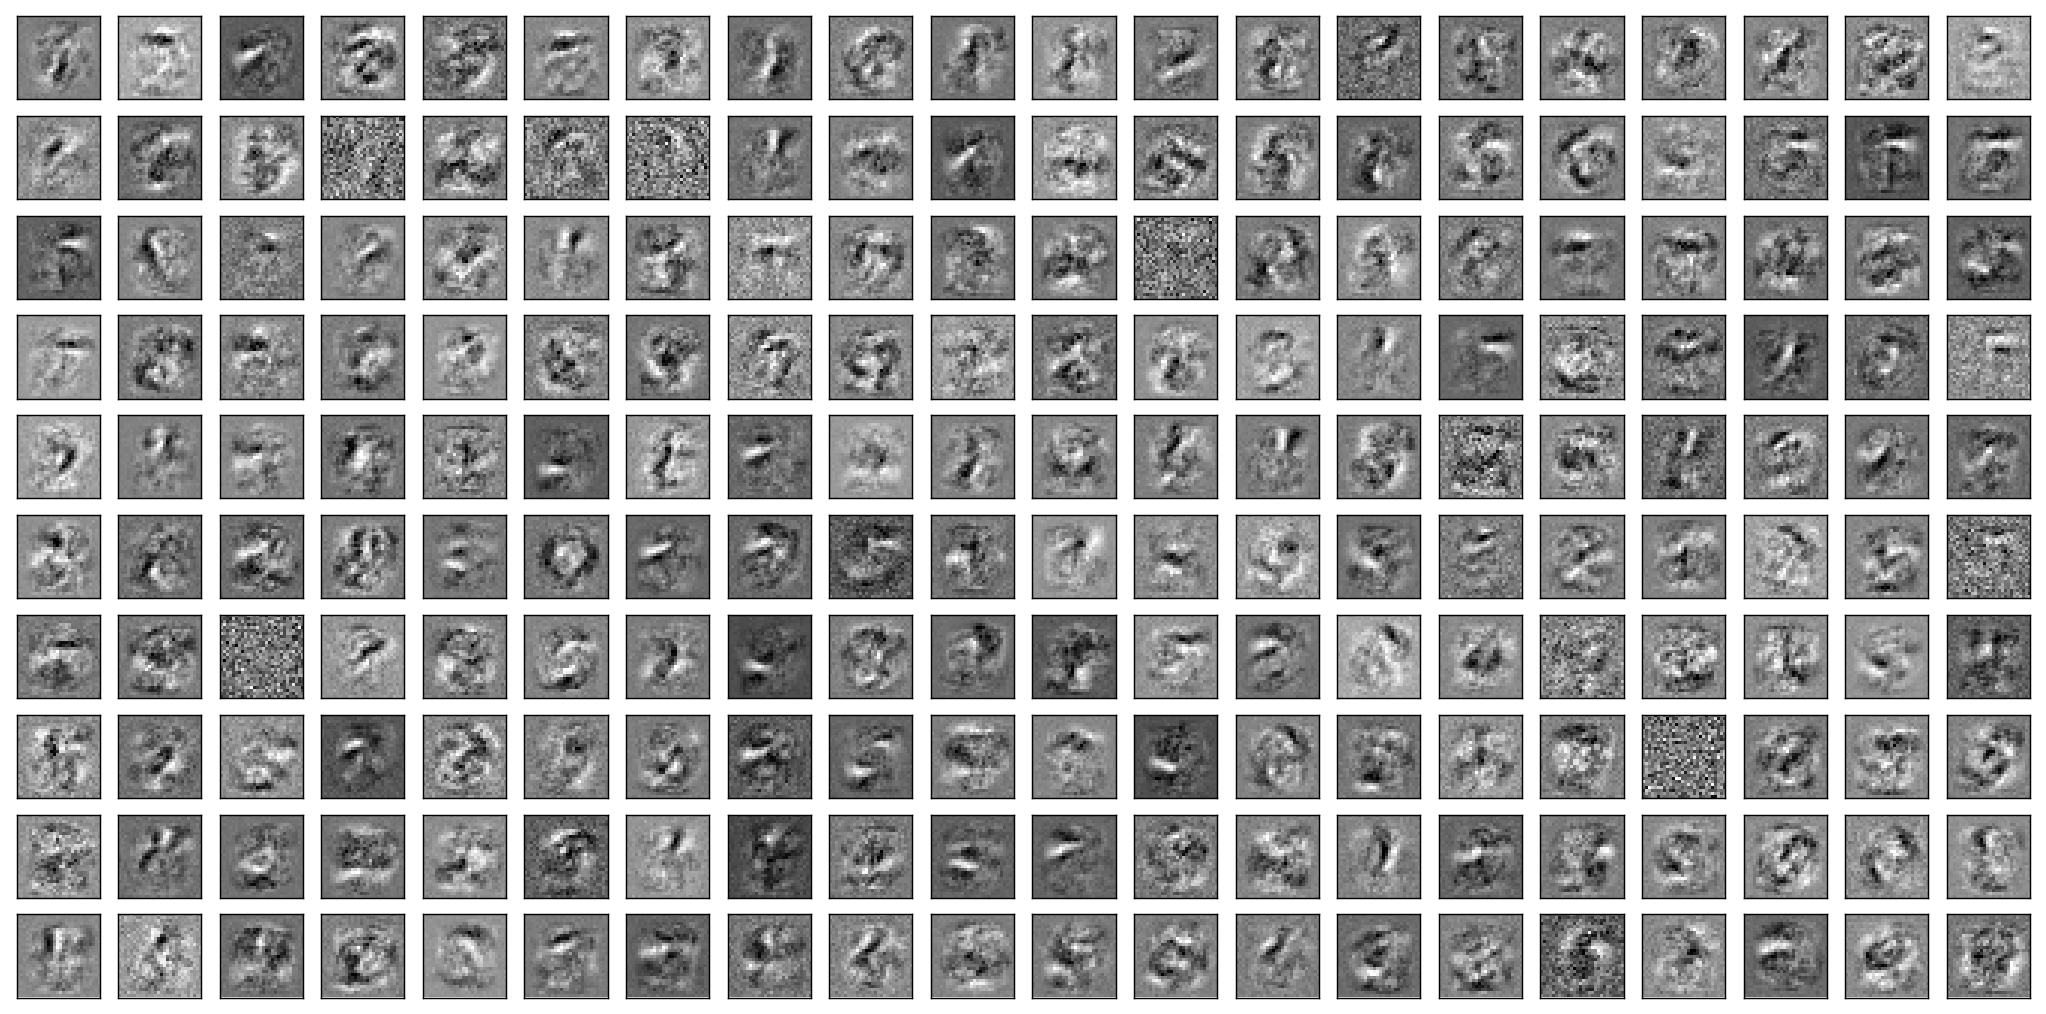

In [364]:
#reshape for visualization
w2=np.reshape(w2[0],(200,28,28))

num_rows = 10
num_cols = 20
num_images = num_rows*num_cols
plt.figure(figsize=(num_cols, num_rows),dpi=130)

for i in range(200):
    plt.subplot(num_rows, num_cols, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(w2[i], cmap=plt.cm.binary)    

#plt.show()
    
plt.savefig("weights_2L.png",dpi=300)

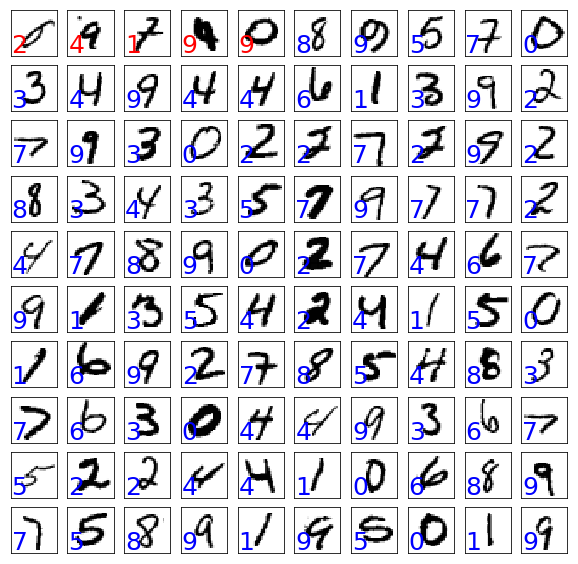

In [365]:
#converting
test_pred = np.argmax(predictions2,axis=1)
test_true = np.argmax(Y_test,axis=1)
test_size = len(test_true)
test_data = np.array(X_test).reshape((10000, 28, 28, 1))

# Extract 100 random test images
batch_test_ind = np.random.choice(test_size,100)
batch_test_ind_wrong_first = batch_test_ind[np.argsort(test_true[batch_test_ind]==test_pred[batch_test_ind])]

# Do the plot of the images
num_rows = 10
num_cols = 10
num_images = num_rows*num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, i_im in enumerate(batch_test_ind_wrong_first, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[i_im,:,:,0], cmap=plt.cm.binary)    
    if test_pred[i_im]==test_true[i_im]:
          plt.text(0, 25, test_pred[i_im], fontsize=25, color='blue')
    else:
          plt.text(0, 25, test_pred[i_im], fontsize=25, color='red')    
                  
plt.savefig("numbers_2L.png",dpi=300)
